In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import time
from IPython.display import clear_output

# Define the grid world environment
class GridWorld:
    def __init__(self, width=5, height=5):
        self.width = width
        self.height = height
        self.start = (0, 0)
        self.goal = (width-1, height-1)
        
        # Define the rewards
        self.rewards = np.zeros((height, width))
        self.rewards[self.goal] = 1.0  # Goal state reward
        
        # Define actions: 0=up, 1=right, 2=down, 3=left
        self.actions = [0, 1, 2, 3]
        self.action_names = ["Up", "Right", "Down", "Left"]
        
    def reset(self):
        self.state = self.start
        return self.state
    
    def step(self, action):
        x, y = self.state
        
        # Move according to the action
        if action == 0:  # Up
            y = max(0, y - 1)
        elif action == 1:  # Right
            x = min(self.width - 1, x + 1)
        elif action == 2:  # Down
            y = min(self.height - 1, y + 1)
        elif action == 3:  # Left
            x = max(0, x - 1)
        
        new_state = (x, y)
        self.state = new_state
        
        # Check if we've reached the goal
        done = new_state == self.goal
        reward = self.rewards[new_state]
        
        return new_state, reward, done

In [2]:
class SARSA:
    def __init__(self, env, alpha=0.1, gamma=0.9, epsilon=0.1):
        self.env = env
        self.alpha = alpha      # Learning rate
        self.gamma = gamma      # Discount factor
        self.epsilon = epsilon  # Exploration rate
        
        # Initialize Q-table with zeros
        self.Q = np.zeros((env.height, env.width, len(env.actions)))
        
    def choose_action(self, state):
        """
        Choose an action using epsilon-greedy policy
        """
        if random.random() < self.epsilon:
            # Explore: random action
            return random.choice(self.env.actions)
        else:
            # Exploit: best action from Q-table
            return np.argmax(self.Q[state[1], state[0]])
    
    def learn(self, episodes=100, max_steps=100):
        """
        SARSA learning algorithm
        """
        rewards_all_episodes = []
        
        for episode in range(episodes):
            state = self.env.reset()
            action = self.choose_action(state)
            total_reward = 0
            done = False
            
            for step in range(max_steps):
                new_state, reward, done = self.env.step(action)
                new_action = self.choose_action(new_state)
                
                # SARSA update
                current_q = self.Q[state[1], state[0], action]
                next_q = self.Q[new_state[1], new_state[0], new_action]
                new_q = current_q + self.alpha * (reward + self.gamma * next_q - current_q)
                self.Q[state[1], state[0], action] = new_q
                
                state = new_state
                action = new_action
                total_reward += reward
                
                if done:
                    break
            
            rewards_all_episodes.append(total_reward)
            
            # Decrease exploration rate over time
            self.epsilon = max(0.01, self.epsilon * 0.995)
            
            # Print episode details periodically
            if episode % 10 == 0:
                print(f"Episode: {episode}, Total Reward: {total_reward}, Epsilon: {self.epsilon:.3f}")
                self.visualize_policy()
        
        return rewards_all_episodes
    
    def visualize_policy(self):
        """
        Visualize the learned policy
        """
        policy = np.zeros((self.env.height, self.env.width), dtype=str)
        
        action_symbols = ["↑", "→", "↓", "←"]
        
        for y in range(self.env.height):
            for x in range(self.env.width):
                best_action = np.argmax(self.Q[y, x])
                policy[y, x] = action_symbols[best_action]
        
        # Mark the goal state
        policy[self.env.goal[1], self.env.goal[0]] = "G"
        
        # Display the policy
        clear_output(wait=True)
        plt.figure(figsize=(8, 6))
        plt.imshow(np.zeros((self.env.height, self.env.width)), cmap='binary', alpha=0.1)
        
        for y in range(self.env.height):
            for x in range(self.env.width):
                plt.text(x, y, policy[y, x], ha='center', va='center', fontsize=14)
        
        plt.grid(color='black', lw=1)
        plt.xticks(np.arange(-0.5, self.env.width, 1), [])
        plt.yticks(np.arange(-0.5, self.env.height, 1), [])
        plt.title("Current Policy")
        plt.show()

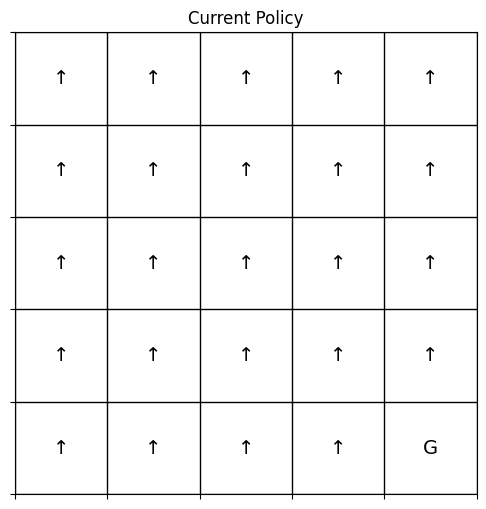

In [3]:
# Create the environment
env = GridWorld(width=5, height=5)

# Create the SARSA agent
agent = SARSA(env, alpha=0.1, gamma=0.9, epsilon=0.3)

# Train the agent
rewards = agent.learn(episodes=100, max_steps=100)

# Plot the rewards
plt.figure(figsize=(10, 6))
plt.plot(rewards)
plt.title('Rewards over Episodes')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.grid(True)
plt.show()

# Display the final policy
agent.visualize_policy()

In [10]:
class CliffWalking:
    def __init__(self, width=12, height=4):
        self.width = width
        self.height = height
        self.start = (0, height-1)  # Bottom left corner
        self.goal = (width-1, height-1)  # Bottom right corner
        
        # Define the rewards
        self.rewards = np.zeros((height, width)) - 0.01  # Small negative reward for each step
        
        # Create the cliff (bottom row except start and goal)
        self.cliff = [(x, height-1) for x in range(1, width-1)]
        for x, y in self.cliff:
            self.rewards[y, x] = -100  # Cliff penalty
        
        self.rewards[self.goal] = 1.0  # Goal state reward
        
        # Define actions: 0=up, 1=right, 2=down, 3=left
        self.actions = [0, 1, 2, 3]
        self.action_names = ["Up", "Right", "Down", "Left"]
    
    def reset(self):
        self.state = self.start
        return self.state
    
    def step(self, action):
        x, y = self.state
        
        # Move according to the action
        if action == 0:  # Up
            y = max(0, y - 1)
        elif action == 1:  # Right
            x = min(self.width - 1, x + 1)
        elif action == 2:  # Down
            y = min(self.height - 1, y + 1)
        elif action == 3:  # Left
            x = max(0, x - 1)
        
        new_state = (x, y)
        self.state = new_state
        
        # Check if we've fallen off the cliff
        if new_state in self.cliff:
            reward = self.rewards[new_state[1], new_state[0]]
            self.state = self.start  # Go back to start if fallen off cliff
            return self.state, reward, False
        
        # Check if we've reached the goal
        done = new_state == self.goal
        reward = self.rewards[new_state[1], new_state[0]]
        
        return new_state, reward, done
    
    def visualize_environment(self):
        """
        Visualize the cliff walking environment
        """
        grid = np.zeros((self.height, self.width))
        
        # Mark cliff
        for x, y in self.cliff:
            grid[y, x] = -1
            
        # Mark start and goal
        grid[self.start[1], self.start[0]] = 1
        grid[self.goal[1], self.goal[0]] = 2
        
        plt.figure(figsize=(12, 4))
        plt.imshow(grid, cmap='coolwarm')
        
        # Add labels
        for y in range(self.height):
            for x in range(self.width):
                if (x, y) == self.start:
                    plt.text(x, y, 'S', ha='center', va='center', color='white', fontsize=12)
                elif (x, y) == self.goal:
                    plt.text(x, y, 'G', ha='center', va='center', color='white', fontsize=12)
                elif (x, y) in self.cliff:
                    plt.text(x, y, 'C', ha='center', va='center', color='white', fontsize=12)
        
        plt.grid(color='black', lw=1)
        plt.title("Cliff Walking Environment")
        plt.show()

In [13]:
class CliffWalking:
    def __init__(self, width=12, height=4):
        self.width = width
        self.height = height
        self.start = (0, height-1)  # Bottom left corner
        self.goal = (width-1, height-1)  # Bottom right corner
        
        # Define the rewards
        self.rewards = np.zeros((height, width)) - 0.01  # Small negative reward for each step
        
        # Create the cliff (bottom row except start and goal)
        self.cliff = [(x, height-1) for x in range(1, width-1)]
        for x, y in self.cliff:
            self.rewards[y, x] = -100  # Cliff penalty
        
        # Fix: properly index the NumPy array with y,x order
        self.rewards[self.goal[1], self.goal[0]] = 1.0  # Goal state reward
        
        # Define actions: 0=up, 1=right, 2=down, 3=left
        self.actions = [0, 1, 2, 3]
        self.action_names = ["Up", "Right", "Down", "Left"]
    
    def reset(self):
        self.state = self.start
        return self.state
    
    def step(self, action):
        x, y = self.state
        
        # Move according to the action
        if action == 0:  # Up
            y = max(0, y - 1)
        elif action == 1:  # Right
            x = min(self.width - 1, x + 1)
        elif action == 2:  # Down
            y = min(self.height - 1, y + 1)
        elif action == 3:  # Left
            x = max(0, x - 1)
        
        new_state = (x, y)
        self.state = new_state
        
        # Check if we've fallen off the cliff
        if new_state in self.cliff:
            reward = self.rewards[new_state[1], new_state[0]]
            self.state = self.start  # Go back to start if fallen off cliff
            return self.state, reward, False
        
        # Check if we've reached the goal
        done = new_state == self.goal
        reward = self.rewards[new_state[1], new_state[0]]
        
        return new_state, reward, done
    
    def visualize_environment(self):
        """
        Visualize the cliff walking environment
        """
        grid = np.zeros((self.height, self.width))
        
        # Mark cliff
        for x, y in self.cliff:
            grid[y, x] = -1
            
        # Mark start and goal
        grid[self.start[1], self.start[0]] = 1
        grid[self.goal[1], self.goal[0]] = 2
        
        plt.figure(figsize=(12, 4))
        plt.imshow(grid, cmap='coolwarm')
        
        # Add labels
        for y in range(self.height):
            for x in range(self.width):
                if (x, y) == self.start:
                    plt.text(x, y, 'S', ha='center', va='center', color='white', fontsize=12)
                elif (x, y) == self.goal:
                    plt.text(x, y, 'G', ha='center', va='center', color='white', fontsize=12)
                elif (x, y) in self.cliff:
                    plt.text(x, y, 'C', ha='center', va='center', color='white', fontsize=12)
        
        plt.grid(color='black', lw=1)
        plt.title("Cliff Walking Environment")
        plt.show()

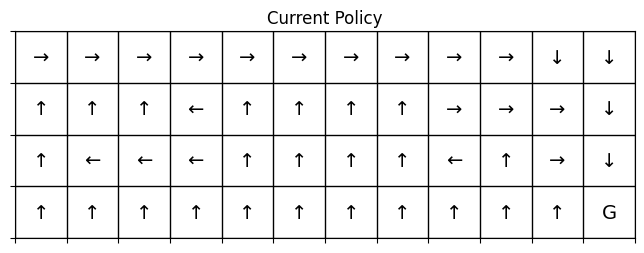

In [14]:
# Create the cliff walking environment
cliff_env = CliffWalking()

# Visualize the environment
cliff_env.visualize_environment()

# Create the SARSA agent
cliff_agent = SARSA(cliff_env, alpha=0.1, gamma=0.9, epsilon=0.3)

# Train the agent
cliff_rewards = cliff_agent.learn(episodes=500, max_steps=200)

# Plot the rewards
plt.figure(figsize=(10, 6))
plt.plot(cliff_rewards)
plt.title('Rewards over Episodes - Cliff Walking')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.grid(True)
plt.show()

# Display the final policy
cliff_agent.visualize_policy()

In [15]:
class QLearning:
    def __init__(self, env, alpha=0.1, gamma=0.9, epsilon=0.1):
        self.env = env
        self.alpha = alpha      # Learning rate
        self.gamma = gamma      # Discount factor
        self.epsilon = epsilon  # Exploration rate
        
        # Initialize Q-table with zeros
        self.Q = np.zeros((env.height, env.width, len(env.actions)))
        
    def choose_action(self, state):
        """
        Choose an action using epsilon-greedy policy
        """
        if random.random() < self.epsilon:
            # Explore: random action
            return random.choice(self.env.actions)
        else:
            # Exploit: best action from Q-table
            return np.argmax(self.Q[state[1], state[0]])
    
    def learn(self, episodes=100, max_steps=100):
        """
        Q-learning algorithm
        """
        rewards_all_episodes = []
        
        for episode in range(episodes):
            state = self.env.reset()
            total_reward = 0
            done = False
            
            for step in range(max_steps):
                action = self.choose_action(state)
                new_state, reward, done = self.env.step(action)
                
                # Q-learning update: uses the max next action value instead of the chosen next action
                current_q = self.Q[state[1], state[0], action]
                max_next_q = np.max(self.Q[new_state[1], new_state[0]])
                new_q = current_q + self.alpha * (reward + self.gamma * max_next_q - current_q)
                self.Q[state[1], state[0], action] = new_q
                
                state = new_state
                total_reward += reward
                
                if done:
                    break
            
            rewards_all_episodes.append(total_reward)
            
            # Decrease exploration rate over time
            self.epsilon = max(0.01, self.epsilon * 0.995)
            
            # Print episode details periodically
            if episode % 10 == 0:
                print(f"Episode: {episode}, Total Reward: {total_reward}, Epsilon: {self.epsilon:.3f}")
                self.visualize_policy()
        
        return rewards_all_episodes
    
    def visualize_policy(self):
        """
        Visualize the learned policy
        """
        policy = np.zeros((self.env.height, self.env.width), dtype=str)
        
        action_symbols = ["↑", "→", "↓", "←"]
        
        for y in range(self.env.height):
            for x in range(self.env.width):
                best_action = np.argmax(self.Q[y, x])
                policy[y, x] = action_symbols[best_action]
        
        # Mark the goal state and cliff
        policy[self.env.goal[1], self.env.goal[0]] = "G"
        for x, y in self.env.cliff:
            policy[y, x] = "C"
        
        # Display the policy
        clear_output(wait=True)
        plt.figure(figsize=(12, 4))
        plt.imshow(np.zeros((self.env.height, self.env.width)), cmap='binary', alpha=0.1)
        
        for y in range(self.env.height):
            for x in range(self.env.width):
                plt.text(x, y, policy[y, x], ha='center', va='center', fontsize=14)
        
        plt.grid(color='black', lw=1)
        plt.xticks(np.arange(-0.5, self.env.width, 1), [])
        plt.yticks(np.arange(-0.5, self.env.height, 1), [])
        plt.title("Q-Learning Policy")
        plt.show()

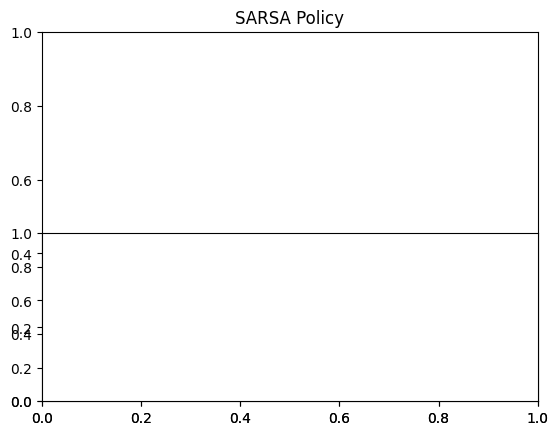

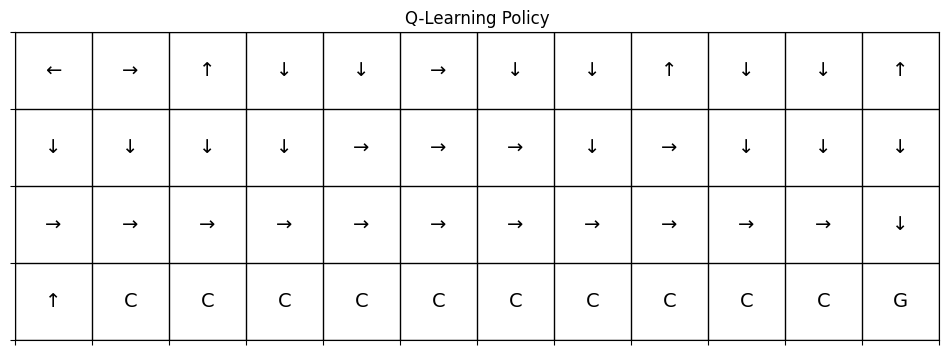

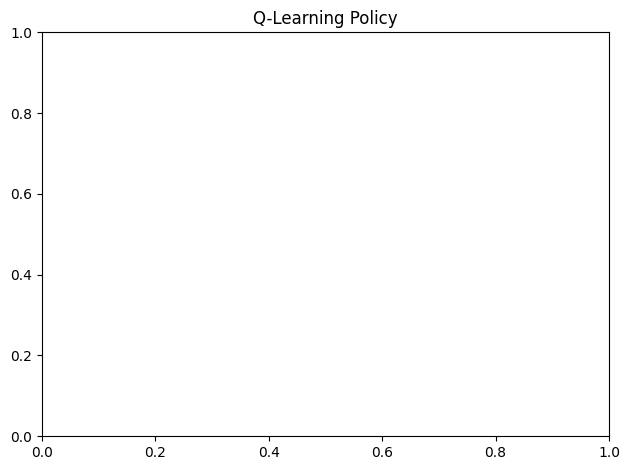

In [16]:
# Create the cliff walking environment for Q-learning
cliff_env_q = CliffWalking()

# Create the Q-learning agent
q_agent = QLearning(cliff_env_q, alpha=0.1, gamma=0.9, epsilon=0.3)

# Train the agent
q_rewards = q_agent.learn(episodes=500, max_steps=200)

# Plot the comparison
plt.figure(figsize=(12, 6))
plt.plot(cliff_rewards, label='SARSA')
plt.plot(q_rewards, label='Q-Learning')
plt.title('SARSA vs Q-Learning on Cliff Walking')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.legend()
plt.grid(True)
plt.show()

# Display the final policies
plt.figure(figsize=(12, 10))

plt.subplot(2, 1, 1)
cliff_agent.visualize_policy()
plt.title("SARSA Policy")

plt.subplot(2, 1, 2)
q_agent.visualize_policy()
plt.title("Q-Learning Policy")

plt.tight_layout()
plt.show()